# Principal Component Analysis to analyze a breast tumor dataset

The approach used in this Jupyter notebook is based on the following article: 
> <div class="csl-entry">Ringnér, M. (2008). What is principal component analysis? <i>Nature Biotechnology</i>, <i>26</i>(3), 303–304. https://doi.org/10.1038/nbt0308-303</div>


## Requirements
- refer to the README.md for an detailed explanation of how to install all required packages
- here, we do all the necessary imports
- download of the [dataset](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE5325) containing breast cancer tumor samples

In [1]:
import GEOparse as GEOparse

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from pathlib import Path
import os

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
# source: https://gist.github.com/cplaisier/4b2c2e3b123df962aa381f706669cce8
# accessed 2021-03-01

gseNums = ["GSE5325"]

for gse1 in gseNums:
    gse = GEOparse.get_GEO(geo=gse1, destdir="./downloads")

    # Get expression data and metadata matrices
    exprs = []
    gsmNames = []
    metadata = {}
    for gsm_name, gsm in gse.gsms.items():
        if gsm.metadata["type"][0] == "RNA":
            # Expression data
            if len(gsm.table) > 0:
                tmp = gsm.table["VALUE"]
                tmp.index = gsm.table["ID_REF"]
                gsmNames.append(gsm_name)
                if len(exprs) == 0:
                    exprs = tmp.to_frame()
                else:
                    exprs = pd.concat([exprs, tmp.to_frame()], axis=1)

            # Metadata
            for key, value in gsm.metadata.items():
                if (key == "characteristics_ch1" or key == "characteristics_ch2") and (
                    len([i for i in value if i != ""]) > 1 or value[0].find(": ") != -1
                ):
                    tmpVal = 0
                    for tmp in value:
                        splitUp = [i.strip() for i in tmp.split(":")]
                        if len(splitUp) == 2:
                            if not splitUp[0] in metadata:
                                metadata[splitUp[0]] = {}
                            metadata[splitUp[0]][gsm_name] = splitUp[1]
                        else:
                            if not key in metadata:
                                metadata[key] = {}
                            metadata[key][gsm_name] = splitUp[0]
                else:
                    if not key in metadata:
                        metadata[key] = {}
                    if len(value) == 1:
                        metadata[key][gsm_name] = " ".join(
                            [j.replace(",", " ") for j in value]
                        )

    # Write expression data matrix to file
    exprs.columns = gsmNames
    with open(gse1 + "_exprs.csv", "w") as outFile:
        exprs.to_csv(outFile)

    # Write metadata matrix to file
    with open(gse1 + "_pData.csv", "w") as outFile:
        outFile.write("Metadata," + ",".join(gsmNames))
        for key in metadata:
            tmp = [key]
            for gsm_name in gsmNames:
                if gsm_name in metadata[key]:
                    tmp.append(metadata[key][gsm_name])
                else:
                    tmp.append("NA")
            outFile.write("\n" + ",".join(tmp))

    # Write out platform information
    for gpl_name, gpl in gse.gpls.items():
        with open(gse1 + "_" + gpl_name + "_gpl.csv", "w") as outFile:
            gpl.table.to_csv(outFile)

09-Jul-2023 18:00:05 DEBUG utils - Directory ./downloads already exists. Skipping.
09-Jul-2023 18:00:05 INFO GEOparse - File already exist: using local version.
09-Jul-2023 18:00:05 INFO GEOparse - Parsing ./downloads/GSE5325_family.soft.gz: 
09-Jul-2023 18:00:05 DEBUG GEOparse - DATABASE: GeoMiame
09-Jul-2023 18:00:05 DEBUG GEOparse - SERIES: GSE5325
09-Jul-2023 18:00:05 DEBUG GEOparse - PLATFORM: GPL3883
09-Jul-2023 18:00:05 DEBUG GEOparse - SAMPLE: GSM120468
09-Jul-2023 18:00:05 DEBUG GEOparse - SAMPLE: GSM120469
09-Jul-2023 18:00:05 DEBUG GEOparse - SAMPLE: GSM120470
09-Jul-2023 18:00:05 DEBUG GEOparse - SAMPLE: GSM120475
09-Jul-2023 18:00:05 DEBUG GEOparse - SAMPLE: GSM120477
09-Jul-2023 18:00:05 DEBUG GEOparse - SAMPLE: GSM120478
09-Jul-2023 18:00:05 DEBUG GEOparse - SAMPLE: GSM120481
09-Jul-2023 18:00:05 DEBUG GEOparse - SAMPLE: GSM120483
09-Jul-2023 18:00:05 DEBUG GEOparse - SAMPLE: GSM120484
09-Jul-2023 18:00:05 DEBUG GEOparse - SAMPLE: GSM120485
09-Jul-2023 18:00:05 DEBUG GEO

## Utils and Helper Functions
- utils function for data processing and plotting
- helper function for data standardization and extraction
- helper function to get a gene status for every sample

In [3]:
# utils for processing data
def make_data_centered(data_array):
    mean = np.mean(data_array, axis=0)
    return data_array - mean


def get_custom_color_map():
    return mcolors.LinearSegmentedColormap.from_list("mycmap", [(0, 0, 0), (1, 0, 0)])


def calc_max_range(data_array):
    return np.max(data_array) - np.min(data_array)


def get_estrogen_receptor_legend(x_data, y_data):
    x_range = calc_max_range(x_data)
    y_range = calc_max_range(y_data)
    return {
        0: {
            "x": np.max(x_data) + 0.1 * x_range,
            "y": np.max(y_data) - 0.1 * y_range,
            "s": "ER+",
            "color": "red",
        },
        1: {
            "x": np.max(x_data) + 0.1 * x_range,
            "y": np.max(y_data) - 0.2 * y_range,
            "s": "ER-",
            "color": "black",
        },
    }


# utils for plotting
def plot_data(x_data, y_data, color_data, x_label, y_label, title):
    plt.scatter(x_data, y_data, c=color_data, cmap=get_custom_color_map(), alpha=0.5)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # set the axis limits
    x_range = calc_max_range(x_data)
    y_range = calc_max_range(y_data)
    plt.xlim(np.min(x_data) - 0.05 * x_range, np.max(x_data) + 0.05 * x_range)
    plt.ylim(np.min(y_data) - 0.05 * y_range, np.max(y_data) + 0.1 * y_range)

    # add a legend
    plt.text(**get_estrogen_receptor_legend(x_data, y_data)[0])
    plt.text(**get_estrogen_receptor_legend(x_data, y_data)[1])

    return plt


def save_plt(plt, filename: str, dpi=600):
    folder = Path("figures/")
    os.makedirs(folder, exist_ok=True)
    f = "jpeg"
    path = Path.joinpath(folder, f"{filename}.{f}")
    plt.savefig(path, format=f, dpi=dpi, bbox_inches='tight')


In [4]:
# utils for data standardization
def get_genome_information():
    return pd.read_csv("GSE5325_GPL3883_gpl.csv").drop(columns=["Unnamed: 0"])


def get_standardized_gene_data(convert_nan_to_zero=True, with_id_column=True):
    # load gene expression data into a Pandas DataFrame
    data = pd.read_csv("GSE5325_exprs.csv")

    # remove rows where all values are NaN, ignoring the `ID_REF` column
    data.dropna(
        how="all", subset=[col for col in data.columns if col != "ID_REF"], inplace=True
    )

    if convert_nan_to_zero:
        # replace remaining NaN values with mean
        data.fillna(0, inplace=True)

    # Get the `ID_REF` column
    id_ref = data["ID_REF"]

    # Remove the `ID_REF` column
    data.drop(columns=["ID_REF"], inplace=True)

    # Standardize the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Convert the standardized data to a DataFrame
    data_scaled = pd.DataFrame(data_scaled, columns=data.columns)

    if with_id_column:
        # Add the `ID_REF` column back to the DataFrame
        data_scaled.insert(0, "ID_REF", id_ref.values)

    return data_scaled


# utils for getting specific data
def get_row_by_gene_symbol(gene_symbol, single_row=False):
    gene_information = get_genome_information()
    gene_id = gene_information[gene_information["GeneSymbol"] == gene_symbol]["ID"]
    gene_expr_data = get_standardized_gene_data()

    # multiple gene_ids can be found for one gene_symbol
    for i in gene_id:
        gene_row = gene_expr_data.loc[gene_expr_data["ID_REF"] == i]
        if not gene_row.empty:
            if single_row:
                return gene_row.drop(columns=["ID_REF"]).values[0]

            return gene_row

    return None


print("with id column")
print(get_row_by_gene_symbol("ESR1"))

print("without id column")
print(get_row_by_gene_symbol("ESR1", single_row=True))

with id column
       ID_REF  GSM120468  GSM120469  GSM120470  GSM120475  GSM120477  \
15589   26581   1.761354  -2.645028   1.803893   4.834758   3.336388   

       GSM120478  GSM120481  GSM120483  GSM120484  ...  GSM120629  GSM120630  \
15589   4.260564   3.829419  -1.628334    2.31476  ...    2.26585   4.322169   

       GSM120631  GSM120632  GSM120633  GSM120634  GSM120635  GSM120636  \
15589   3.833079   3.854015   3.652162  -1.238906   1.785067   3.889902   

       GSM120637  GSM120639  
15589   3.059416   1.866519  

[1 rows x 106 columns]
without id column
[ 1.76135430e+00 -2.64502757e+00  1.80389327e+00  4.83475791e+00
  3.33638837e+00  4.26056375e+00  3.82941940e+00 -1.62833391e+00
  2.31475975e+00 -4.41871790e+00  4.52417496e+00  1.77911559e+00
  3.10826358e+00 -2.60946990e+00  2.52485223e+00  3.95202079e+00
 -3.29565497e+00  4.69034419e+00  3.81952896e+00 -9.87908039e-01
 -2.30124241e+00  4.49277627e+00 -1.73265393e+00 -3.17429266e+00
  2.12332226e+00  2.42314181e+00  3.

In [5]:
# get specific gene status for every sample
# default value is ESR1, which is the estrogen receptor status
def get_gene_status(gene="ESR1", single_row=True):
    gene_row = get_row_by_gene_symbol(gene)

    if gene_row is None:
        return None

    # retrieve in the data which samples have a negative or positive gene status
    # e.g., estrogen receptor status (ER+ or ER-) found in ESR1
    samples_er = []
    for i in gene_row:
        if gene_row[i].values[0] > 0:
            samples_er.append(1)
        else:
            samples_er.append(0)

    df = pd.DataFrame([samples_er], columns=gene_row.columns).drop(columns=["ID_REF"])
    if single_row:
        return df.values[0]
    else:
        return df


print(get_gene_status(single_row=False))
print(get_gene_status(single_row=True))

   GSM120468  GSM120469  GSM120470  GSM120475  GSM120477  GSM120478  \
0          1          0          1          1          1          1   

   GSM120481  GSM120483  GSM120484  GSM120485  ...  GSM120629  GSM120630  \
0          1          0          1          0  ...          1          1   

   GSM120631  GSM120632  GSM120633  GSM120634  GSM120635  GSM120636  \
0          1          1          1          0          1          1   

   GSM120637  GSM120639  
0          1          1  

[1 rows x 105 columns]
[1 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 1 1 1 1 0
 1 0 0 0 1 0 1 1 0 1 1 1 1 0 0 0 1 1 1 0 0 1 0 1 1 1 1 0 1 0 0 0 1 1 0 1 1
 1 0 1 0 0 0 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1]


## Start of the Analysis
### Plotting two genes against each other
- visualizing two genes: GATA3, XBP1
- scatter plot to visualize the expression values of the two genes against each other, where each dot represents a breast cancer sample
- dots are colored based on the estrogen receptor status (ER+ or ER-), which represents the gene ESR1


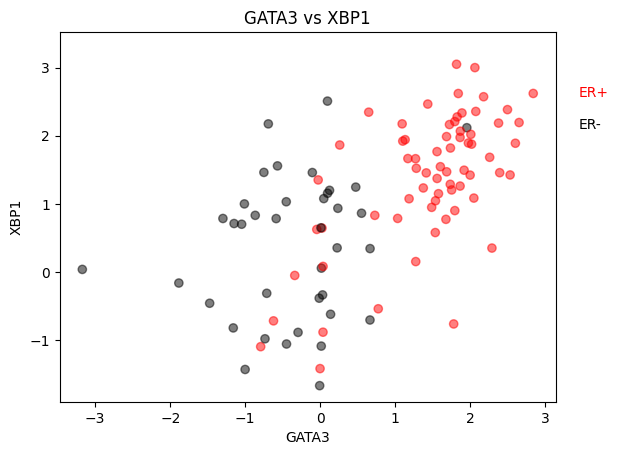

In [6]:
gene1 = "GATA3"
gene2 = "XBP1"

gene1_row = get_row_by_gene_symbol(gene1, single_row=True)
gene2_row = get_row_by_gene_symbol(gene2, single_row=True)

er_status = get_gene_status()

# plot the data
plt = plot_data(
    x_data=gene1_row,
    y_data=gene2_row,
    title=f"{gene1} vs {gene2}",
    x_label=gene1,
    y_label=gene2,
    color_data=er_status,
)

save_plt(plt, "two_genes_plotted")
plt.show()

### Principal Components of two genes
- create a scatter plot to visualize the expression values of the two genes
- find the first two principal components for the sub dataset of two genes and visualize them in the plot

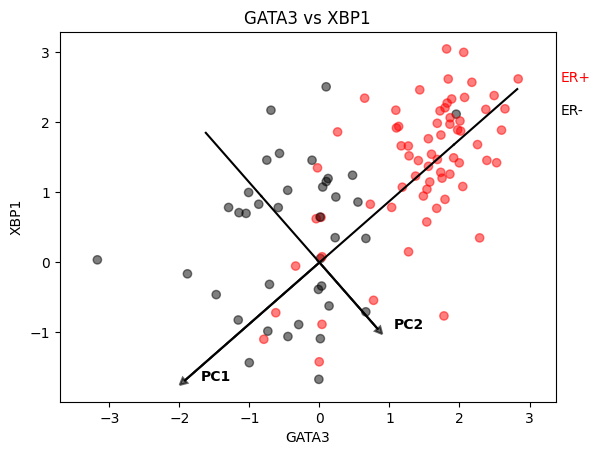

In [7]:
data_array = np.column_stack((gene1_row, gene2_row))

pca = PCA(n_components=2)
pca.fit(data_array)

plt = plot_data(
    x_data=gene1_row,
    y_data=gene2_row,
    title=f"{gene1} vs {gene2}",
    x_label=gene1,
    y_label=gene2,
    color_data=er_status,
)

# draw the principal components
max_abs_value = np.abs(pca.components_).max()
for idx, vector in enumerate(pca.components_):
    # Scaling by variance
    v = vector * np.sqrt(pca.explained_variance_[idx]) * max_abs_value * 2.3
    plt.plot([-v[0], v[0]], [-v[1], v[1]], color="black", linewidth=1.5)

    # Modify the length of the negative part of the line
    line_length = max_abs_value * 1.6
    plt.plot(
        [-v[0], -v[0] - line_length * vector[0]],
        [-v[1], -v[1] - line_length * vector[1]],
        color="black",
        linewidth=1.5,
    )

    plt.arrow(
        0,
        0,
        v[0],
        v[1],
        color="black",
        alpha=0.6,
        linewidth=1.5,
        head_width=0.1,
        head_length=0.1,
    )

    plt.text(
        v[0] + 0.66,
        v[1],
        f"PC{idx+1}",
        color="black",
        fontsize=10,
        ha="right",
        weight="bold",
    )

plt.axis("equal")

save_plt(plt, "two_genes_plotted_with_pca_axis")
plt.show()

### Projection of two genes onto one dimension
- samples are plotted in one direction
- the first principal component is used for this

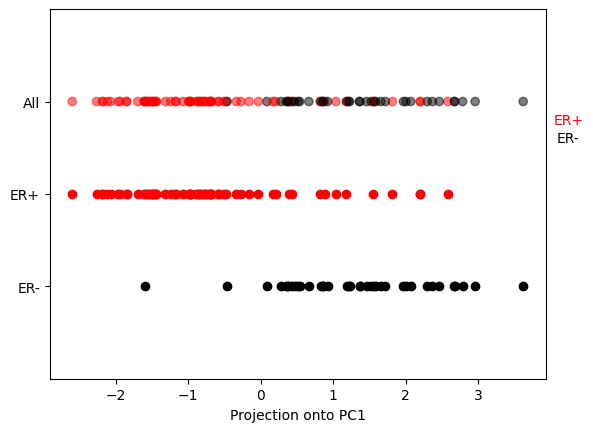

In [8]:
# load the data
genes = ["GATA3", "XBP1"]
data_array = np.column_stack(
    [get_row_by_gene_symbol(gene, single_row=True) for gene in genes]
)

er_status = get_gene_status()

# perform pca
pca = PCA(n_components=1)
data_array_pc1 = pca.fit_transform(data_array)

# define the height of the y-axis
y_heights = [5, 0, -5]
y_labels = ["All", "ER+", "ER-"]

# define colors for ER status
er_colors = ["red", "black"]


# plot the all samples
plt.scatter(
    data_array_pc1,
    [y_heights[0]] * len(data_array_pc1),
    c=er_status,
    cmap=get_custom_color_map(),
    alpha=0.5,
)

# Plot ER+ and ER- samples
for status, height, color in zip([1, 0], y_heights[1:], er_colors):
    er_data = [
        data_array_pc1[i][0] if er_status[i] == status else None
        for i in range(len(data_array_pc1))
    ]
    plt.scatter(er_data, [height] * len(er_data), color=color)

# Add descriptions
plt.yticks(y_heights, y_labels)
x_range = calc_max_range(data_array_pc1)
plt.xlim(
    np.min(data_array_pc1) - 0.05 * x_range, np.max(data_array_pc1) + 0.05 * x_range
)
plt.ylim(min(y_heights) - 5, max(y_heights) + 5)

# legend and label
legends = get_estrogen_receptor_legend(data_array_pc1, pd.DataFrame(y_heights))
for legend_key in legends:
    plt.text(**legends[legend_key], ha="center", va="center")

plt.xlabel("Projection onto PC1")

save_plt(plt, "two_genes_plotted_on_pca1")
plt.show()

### Visualization of the Distribution of Variance
- PCA is applied to all genes with expression levels for all samples
- then the variance of each principal component is visualized

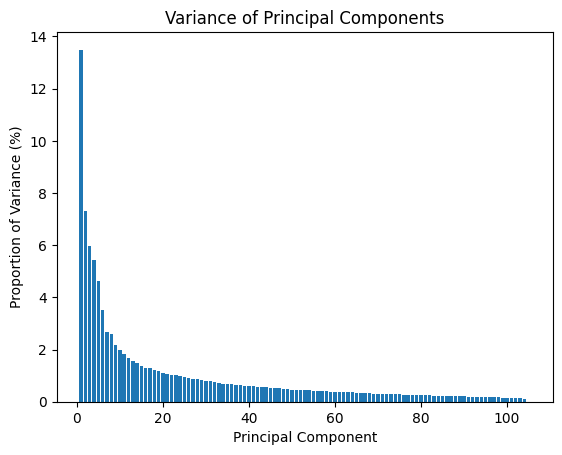

In [9]:
# load the gene expression data and remove also all NaN values which got converted to 0
data = get_standardized_gene_data(convert_nan_to_zero=False, with_id_column=False)
data.dropna(inplace=True)

# Transpose the data so that rows are samples and columns are genes
data = data.T

# Apply PCA to the gene expression data
pca = PCA()
pca.fit(data)

# Get the variance of each principal component
variance = pca.explained_variance_ratio_
variance_percent = variance * 100

# Plot the variance of each principal component
plt.bar(np.arange(1, len(variance_percent) + 1), variance_percent)
plt.xlabel("Principal Component")
plt.ylabel("Proportion of Variance (%)")
plt.title("Variance of Principal Components")

save_plt(plt, "variance_of_principal_components")
plt.show()

In [10]:
# calculate how much variance is explained by the first two principal components
pca = PCA(2)
pca.fit(data)

# Get the variance of each principal component
variance = pca.explained_variance_ratio_
variance_percent = variance * 100

print(f"the first two principal components have {np.sum(variance_percent)}% of the variance")

the first two principal components have 20.810614512537125% of the variance


In [11]:
# calculate how many principal components are needed to explain 90% of the variance

# apply PCA to the gene expression data
pca = PCA()

# fit the PCA model to the data
pca.fit(data)

# calculate how many principal components are needed to explain 90% of the variance
n_components = np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.9)[0][0] + 1

print("Number of principal components needed to explain 90% of the variance:", n_components)


Number of principal components needed to explain 90% of the variance: 62


In [12]:
# calculate how many principal components are needed to explain nearly 100% of the variance

# apply PCA to the gene expression data
pca = PCA()

# fit the PCA model to the data
pca.fit(data)

# calculate how many principal components are needed to explain nearly 100% of the variance
n_components = np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.999999999999999)[0][0] + 1

print("Number of principal components needed to explain nearly 100% of the variance:", n_components)


Number of principal components needed to explain nearly 100% of the variance: 104


### All samples plotted in two dimensions
- PCA biplot using the projection onto the first two principal components
- additionally, the two genes XBP1 and CCNB2 are plotted using their weights for the components
  - note that the scale of the weights of the genes are scalled up by 950


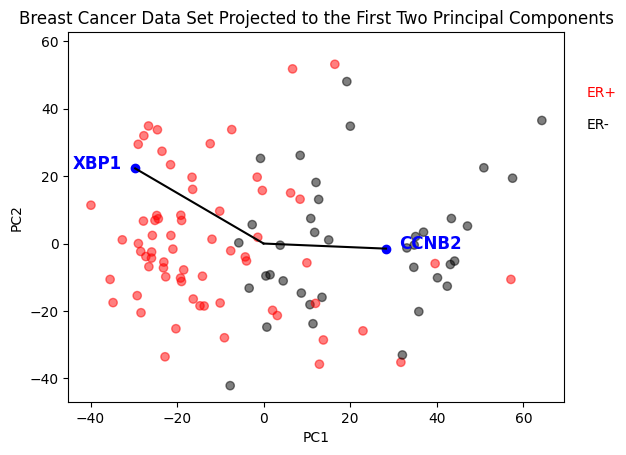

In [13]:
def get_gene_weights(gene, pca, _data):
    gene_row = get_row_by_gene_symbol(gene)
    id_ref = gene_row["ID_REF"].values[0]
    _data = get_standardized_gene_data()
    row_index = _data[_data["ID_REF"] == id_ref].index[0]

    # Get the weights for the gene
    gene_weights = pca.components_[:, row_index]

    return gene_weights


# Load breast cancer dataset
data = get_standardized_gene_data(with_id_column=False).T

er_status = get_gene_status()

# Perform PCA on the data
# and project the data onto the first two principal components
pca = PCA(n_components=2)
projected = pca.fit_transform(data)

# Plot the projected data
plot_data(
    x_data=projected[:, 0],
    y_data=projected[:, 1],
    title="Breast Cancer Dataset Projected onto First Two Principal Components",
    x_label="PC1",
    y_label="PC2",
    color_data=er_status,
)

# Get the weights for the two genes
# and scale them up for plotting
scale = 950
weights_xbp1 = get_gene_weights("XBP1", pca, data) * scale
weights_ccnb2 = get_gene_weights("CCNB2", pca, data) * scale

# Plot the gene weights
plt.scatter(*weights_xbp1, color="blue", label="XBP1")
plt.scatter(*weights_ccnb2, color="blue", label="CCNB2")

# Plot lines from the origin to the gene weights
plt.plot([0, weights_xbp1[0]], [0, weights_xbp1[1]], color="black")
plt.plot([0, weights_ccnb2[0]], [0, weights_ccnb2[1]], color="black")

# Add gene labels
plt.text(
    weights_xbp1[0] - 3,
    weights_xbp1[1],
    "XBP1",
    fontsize=12,
    ha="right",
    color="blue",
    weight="bold",
)
plt.text(
    weights_ccnb2[0] + 3,
    weights_ccnb2[1],
    "CCNB2",
    fontsize=12,
    ha="left",
    color="blue",
    weight="bold",
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Breast Cancer Data Set Projected to the First Two Principal Components")

save_plt(plt, "projected_onto_first_two_principal_components_with_er_status")
plt.show()

- now, same plotting as used in the example before
- but different coloring: the dots of each sample now indicate the ERBB2 status 
    - ERBB2+ is blue
    - ERBB2- is brown

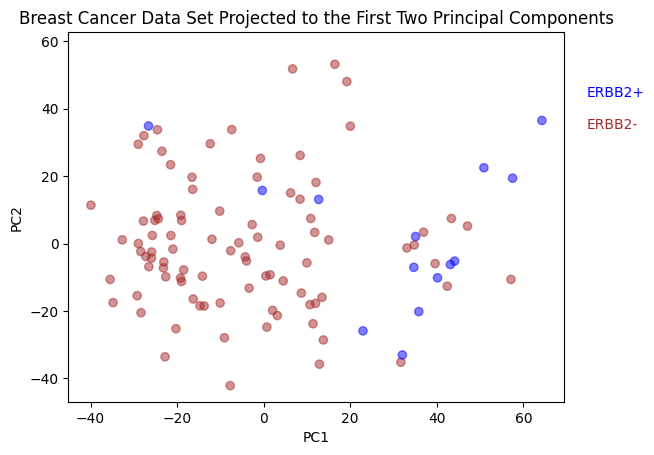

In [14]:
erbb2 = "ERBB2"
erbb2_status = get_gene_status(gene=erbb2)

colors = ["blue", "brown"]
custom_cmap = matplotlib.colors.ListedColormap(colors)

x_data = projected[:, 0]
y_data = projected[:, 1]
plt.scatter(x_data, y_data, c=erbb2_status, cmap=custom_cmap, alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")

x_range = calc_max_range(x_data)
y_range = calc_max_range(y_data)
plt.xlim(np.min(x_data) - 0.05 * x_range, np.max(x_data) + 0.05 * x_range)
plt.ylim(np.min(y_data) - 0.05 * y_range, np.max(y_data) + 0.1 * y_range)

plt.text(
    x=np.max(x_data) + 0.1 * x_range,
    y=np.max(y_data) - 0.1 * y_range,
    s=f"{erbb2}+",
    color=colors[0],
)
plt.text(
    x=np.max(x_data) + 0.1 * x_range,
    y=np.max(y_data) - 0.2 * y_range,
    s=f"{erbb2}-",
    color=colors[1],
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Breast Cancer Data Set Projected to the First Two Principal Components")

save_plt(plt, "projected_onto_first_two_principal_components_with_erbb2")
plt.show()